# Investigation Into the Most Significant Indicators of Heart Disease 

Baiya Griffiths - 26409599\
Grace Li - 62540075\
Andrew Wang - 91790451\
Zhaolan Wang - 70239009

In this project we are looking at Coronary artery disease, a common heart disease where the major blood vessels are clogged or narrowed. Due to the blockage it is difficult to transfer oxygen, blood and nutrients to the heart. Usually this disease can be attributed to cholesterol deposits, so the level of cholesterol in potential victims is of interest to us. The symptoms of coronary artery disease are often reflected in the type of chest pain, resting blood pressure, max heart rate and so on.

Question: Based on a limited set of test data, is a person at risk for coronary heart disease?
We will aim to identify an easily attainable set of variables that lead to an accurate prediction of heart disease. This could be used as an initial screening to determine risk of heart disease and prioritise additional testing to people at higher risk. We are going to take the data with different variables to train, test, and find the accuracy to determine which set of variables can be used for effective screening. 

The dataset we chose was the one about heart disease. The database for heart disease contains 76 attributes (variables), but the dataset we are using includes only 14 of them. In our project, we will focus on determining the presence or absence of heart disease, so the data in the disease column has only two categories, 0 (no heart disease) and 1 (with heart disease). Also, this database has four regional datasets, and we finally chose the Hungarian regional. 

In [2]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(tidymodels)
require(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
#First step is to read the data and label the column names. 
heart_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",col_name = FALSE)
colnames(heart_data) <- c("age", "sex", "chest_pain", "resting_bp", "cholesterol", "fbs>120mg/dL", "restingecg", "max_heart_rate", "exercise_induced_angina", "oldpeak", "slope", "ca", "thal", "disease")

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#Here we are tidying the data by filtering out columns with "?" and selecting which columns we want. 
heart_data_tidy <- heart_data |> select(chest_pain, resting_bp, cholesterol, restingecg, max_heart_rate, disease) |>
                   filter(chest_pain!= "?", resting_bp!= "?", cholesterol!= "?", restingecg!= "?", max_heart_rate!= "?", disease!= "?") |>
                   mutate(chest_pain = as.numeric(chest_pain), 
                          resting_bp = as.numeric(resting_bp),
                          cholesterol = as.numeric(cholesterol),
                          restingecg = as.numeric(restingecg),
                          max_heart_rate = as.numeric(max_heart_rate),
                          disease = as_factor(disease))

In [5]:
heart_split <- initial_split(heart_data_tidy, prop = .75, strata = disease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)
heart_train

chest_pain,resting_bp,cholesterol,restingecg,max_heart_rate,disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,120,243,0,160,0
1,170,237,1,170,0
2,100,219,1,150,0
⋮,⋮,⋮,⋮,⋮,⋮
3,130,294,1,100,1
2,180,393,0,110,1
4,130,275,1,115,1


In [6]:
#Preliminary exploratory data analysis; missing values were ommited so there are zero rows with missing values
#Finding mean of all numerical predictors
heart_data_miss_num <- heart_train |>
                       map_df(is.na) |>
                       map_df(sum)
heart_data_miss_num

heart_data_obs_num <- heart_train |>
                      summarize(n_cp=n(),n_rbp=n(),n_cholesterol=n(),n_max_heart_rate=n(),n_disease=n())
heart_data_obs_num

heart_data_mean <- heart_train |>
    select(resting_bp, cholesterol, max_heart_rate) |>
    map_dfr(mean)
heart_data_mean

#Finding number of observations for each class
heart_num_class <- heart_train |>
    group_by(disease) |>
    summarize(n=n())
heart_num_class

chest_pain,resting_bp,cholesterol,restingecg,max_heart_rate,disease
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


n_cp,n_rbp,n_cholesterol,n_max_heart_rate,n_disease
<int>,<int>,<int>,<int>,<int>
201,201,201,201,201


resting_bp,cholesterol,max_heart_rate
<dbl>,<dbl>,<dbl>
130.1642,248.8159,139.194


disease,n
<fct>,<int>
0,126
1,75


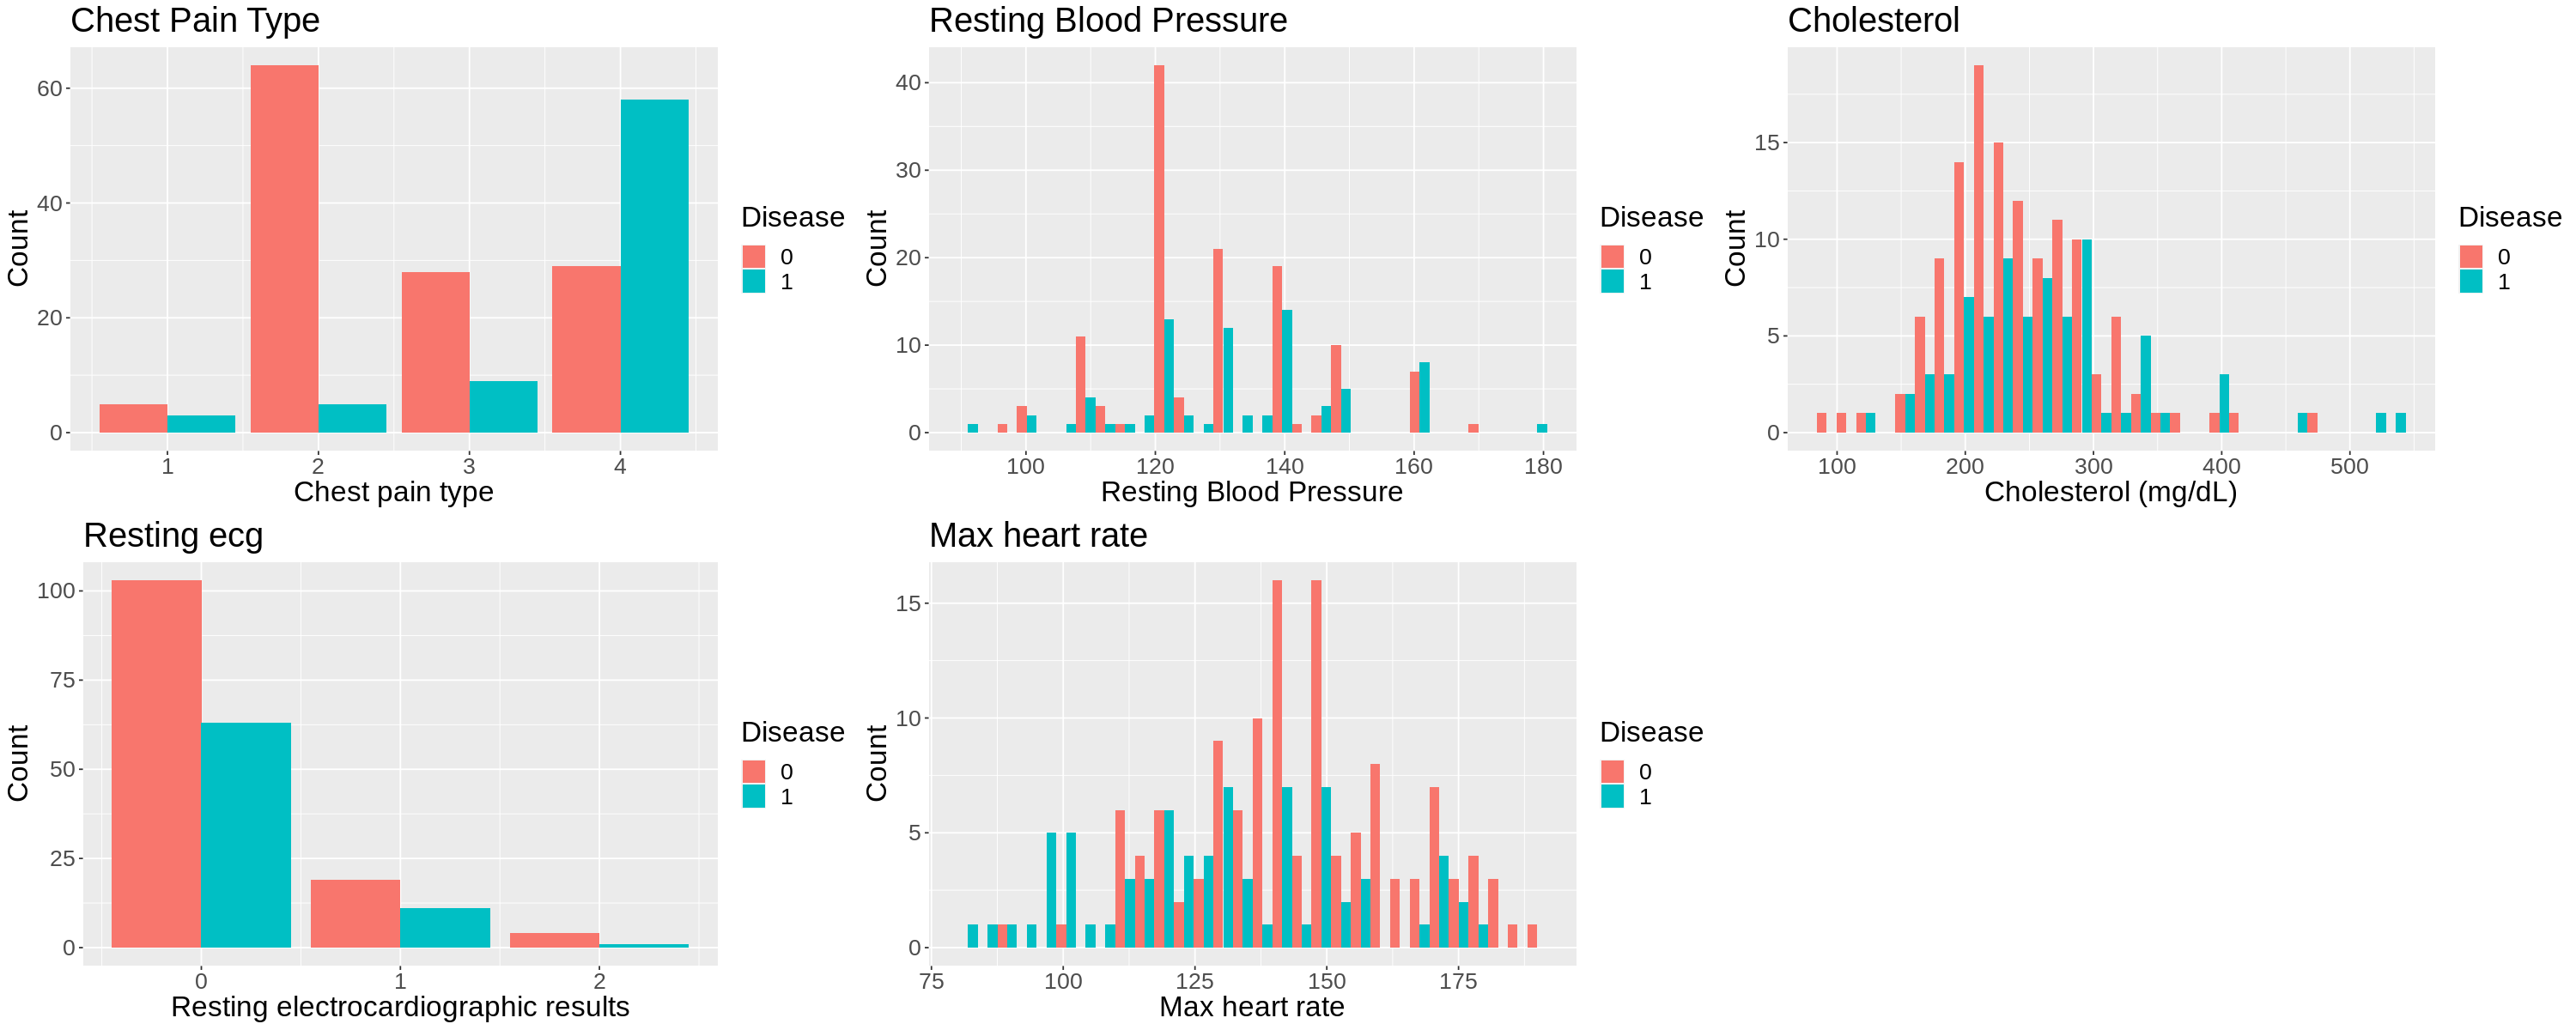

In [7]:
#Preliminary exploratory data analysis; visualization of predictor distribution
options(repr.plot.height = 10, repr.plot.width = 25)
chest_pain_plot <- ggplot(heart_train , 
                   aes(x = chest_pain, fill = disease)) +
                   geom_bar(position= "dodge") +
                   labs(x = "Chest pain type", y = "Count",  fill = "Disease") +
                   ggtitle("Chest Pain Type") +
                   theme(text = element_text(size = 20))
restingbp_plot <- ggplot(heart_train , 
                   aes(x = resting_bp, fill = disease)) +
                   geom_histogram(position= "dodge", bins=30) +
                   labs(x = "Resting Blood Pressure", y = "Count",  fill = "Disease") +
                   ggtitle("Resting Blood Pressure") +
                   theme(text = element_text(size = 20))
chol_plot <- ggplot(heart_train , 
                   aes(x = cholesterol, fill = disease)) +
                   geom_histogram(position= "dodge", bins=30) +
                   labs(x = "Cholesterol (mg/dL)", y = "Count",  fill = "Disease") +
                   ggtitle("Cholesterol") +
                   theme(text = element_text(size = 20))
restingecg_plot <- ggplot(heart_train , 
                   aes(x = restingecg, fill = disease)) +
                   geom_bar(position= "dodge") +
                   labs(x = "Resting electrocardiographic results", y = "Count",  fill = "Disease") +
                   ggtitle("Resting ecg") +
                   theme(text = element_text(size = 20))
max_heart_rate_plot <- ggplot(heart_train , 
                   aes(x = max_heart_rate, fill = disease)) +
                   geom_histogram(position= "dodge", bins=30) +
                   labs(x = "Max heart rate", y = "Count",  fill = "Disease") +
                   ggtitle("Max heart rate") +
                   theme(text = element_text(size = 20))
grid.arrange(chest_pain_plot, restingbp_plot, chol_plot, restingecg_plot, max_heart_rate_plot ,nrow=2)

In [38]:
# training the classifier 
set.seed(1234)

# creating a recipe
heart_recipe <- recipe(disease ~., data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# creating a model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# cross-validation
heart_vfold <- vfold_cv(heart_train, v = 5, strata = disease)

# create tibble with possible k-values
k_vals <- tibble(neighbors = seq(from = 1, to = 70, by = 5))

# training a workflow
knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics()

In [39]:
accuracies <- knn_fit |> 
    filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7067073,5,0.02331231,Preprocessor1_Model01
6,accuracy,binary,0.7662195,5,0.02301827,Preprocessor1_Model02
11,accuracy,binary,0.7162195,5,0.02231207,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,accuracy,binary,0.7565854,5,0.03393521,Preprocessor1_Model12
61,accuracy,binary,0.7265854,5,0.02000948,Preprocessor1_Model13
66,accuracy,binary,0.7017073,5,0.02996218,Preprocessor1_Model14


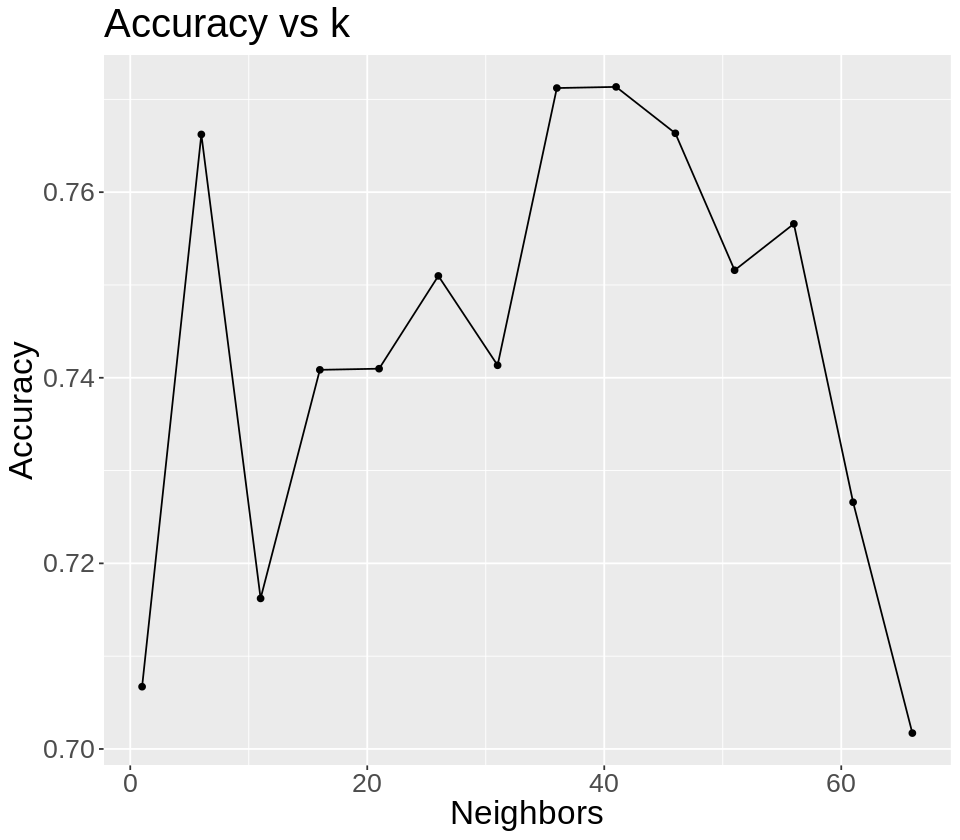

In [40]:
options(repr.plot.width = 8, repr.plot.height = 7)
best_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy") +
    ggtitle("Accuracy vs k") +
    theme(text = element_text(size = 20))
best_k

From the above graph, we can see that the best k-value is around 37 to 40. For this project, we will use k=38.

In [44]:
# make a new model with k=38
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 38) |>
  set_engine("kknn") |>
  set_mode("classification")

# make a new workflow using the new model
knn_best_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_train)

knn_best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(38,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2636816
Best kernel: rectangular
Best k: 38

In [46]:
# determine the accuracy of our model using testing data
heart_test_predictions <- predict(knn_best_fit, heart_test) |>
  bind_cols(heart_test) |>
  metrics(truth = disease, estimate = .pred_class) |>
  filter(.metric == "accuracy")

heart_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7794118
